In [1]:
# Imports
import random
import numpy as np
import random
import gymnasium as gym
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML

In [2]:
#Setting up the taxi_environment
taxi_env = gym.make('Taxi-v3')

taxi_env.reset()

#Current State
print(taxi_env.unwrapped.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", taxi_env.unwrapped.observation_space.n)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the taxi_environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", taxi_env.unwrapped.action_space.n)


123
Number of states: 500
Number of actions that an agent can take: 6


In [3]:
from IPython.display import clear_output
import time

In [4]:
policyOptionR = np.array([[1,3,0,0,0],
                 [1,3,0,0,0],
                 [1,3,3,3,3],
                 [1,1,1,1,1],
                 [1,1,1,1,1]
                 ])
policyOptionG = np.array([[0,0,2,2,1],
                 [0,0,2,2,1],
                 [2,2,2,1,1],
                 [1,2,1,1,1],
                 [1,2,1,1,1]
                 ])
policyOptionY = np.array([[0,3,0,0,0],
                          [0,3,0,0,0],
                          [0,3,3,3,3],
                          [0,1,1,1,3],
                          [0,1,3,1,3]
                          ])
policyOptionB = np.array([[0,0,0,0,3],
                          [0,0,0,0,3],
                          [2,2,2,0,3],
                          [1,1,1,0,3],
                          [1,1,1,0,3]
                          ])
policyOpt = [policyOptionR,policyOptionG,policyOptionY,policyOptionB]

In [5]:
# epsilon-greedy action selection function
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    #print('greedy', np.argmax(q_values[state]),q_values.shape)
    return np.argmax(q_values[state])
  choice = random.randint(0,q_values.shape[-1]-1)
  #print('random',choice,q_values.shape)
  return choice

Defining an option:

In [6]:
nO = 4 #number of options
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}
def Option(taxi_env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=taxi_env.unwrapped.decode(state)

  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5
      else:
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps)
  return [optact,optdone]


# Now the new action space will contain
# Primitive Actions: ["south", "north", "east", "west","pick","drop"]
# Options: ["OptionR","OptionG","OptionY","OptionB"]
# Total Actions :["south", "north", "east", "west","pick","drop","OptionR","OptionG","OptionY","OptionB"]
# Corresponding to [0,1,2,3,4,5,6,7,8,9]


## SMDP Q-learning

In [7]:
#### SMDP Q-Learning

rewards_SMDP = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}

gamma = 0.9
alpha = 0.1
nO = 4 #number of options
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop,nO))
updates_SMDP = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((taxi_env.unwrapped.observation_space.n//20,taxi_env.unwrapped.action_space.n)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
N = 5000

# Iterate over N episodes
for i in range(N):
    state, _ = taxi_env.reset()
    done = False
    tot_rew = 0
    # While episode is not over
    while not done:

        # Choose action
        x,y,pas,drop = taxi_env.unwrapped.decode(state)
        subState = nDrop*pas+drop
        option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state

        #Go to location and drop/pick
        x,y,pas,drop = taxi_env.unwrapped.decode(state)
        optdone = False
        while not optdone and not done:
          optact,optdone = Option(taxi_env,state,Qopt,option,eps[option])

          [x,y,_,_]=  list(taxi_env.unwrapped.decode(state))

          next_state, reward, terminated, truncated,_ = taxi_env.step(optact)
          done = terminated or truncated
          [x1,y1,_,_]=  list(taxi_env.unwrapped.decode(next_state))
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          reward_surr = reward
          if optdone:
            reward_surr = 20
          # if optact<4:
          Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state



            #--
        _,_,pas,drop = taxi_env.unwrapped.decode(state)
        subState = nDrop*pas+drop

        _,_,pas,drop = taxi_env.unwrapped.decode(prev)
        subPrev = nDrop*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards_SMDP.append(tot_rew)
    x,y,pas,drop = taxi_env.unwrapped.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      # print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))



Above success rate is number of no. of times passenger dropped at correct destination out of total number of episodes.

In [8]:
print("max reward", max(rewards_SMDP))

max reward 15


Text(0.5, 1.0, 'SMDP')

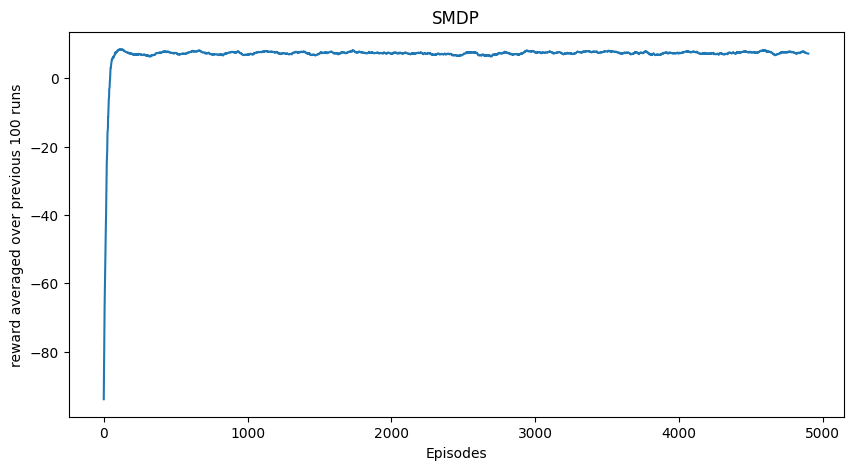

In [9]:
plt.figure(figsize = (10,5))
avg_rews_SMDP = [np.average(rewards_SMDP[i:i+100]) for i in range(len(rewards_SMDP)-100)]
plt.plot(avg_rews_SMDP,label = 'Model Score')
plt.xlabel('Episodes')
plt.ylabel('reward averaged over previous 100 runs')
plt.title('SMDP')
# plt.legend()

Text(0.5, 1.0, 'Policy learnt by SMDP')

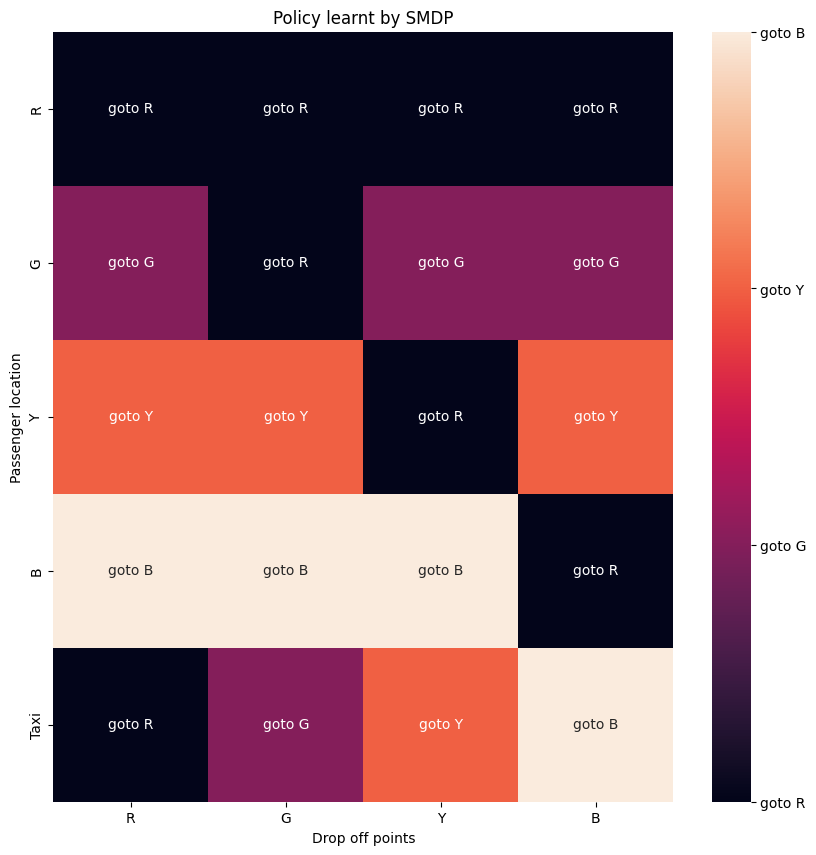

In [10]:
Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

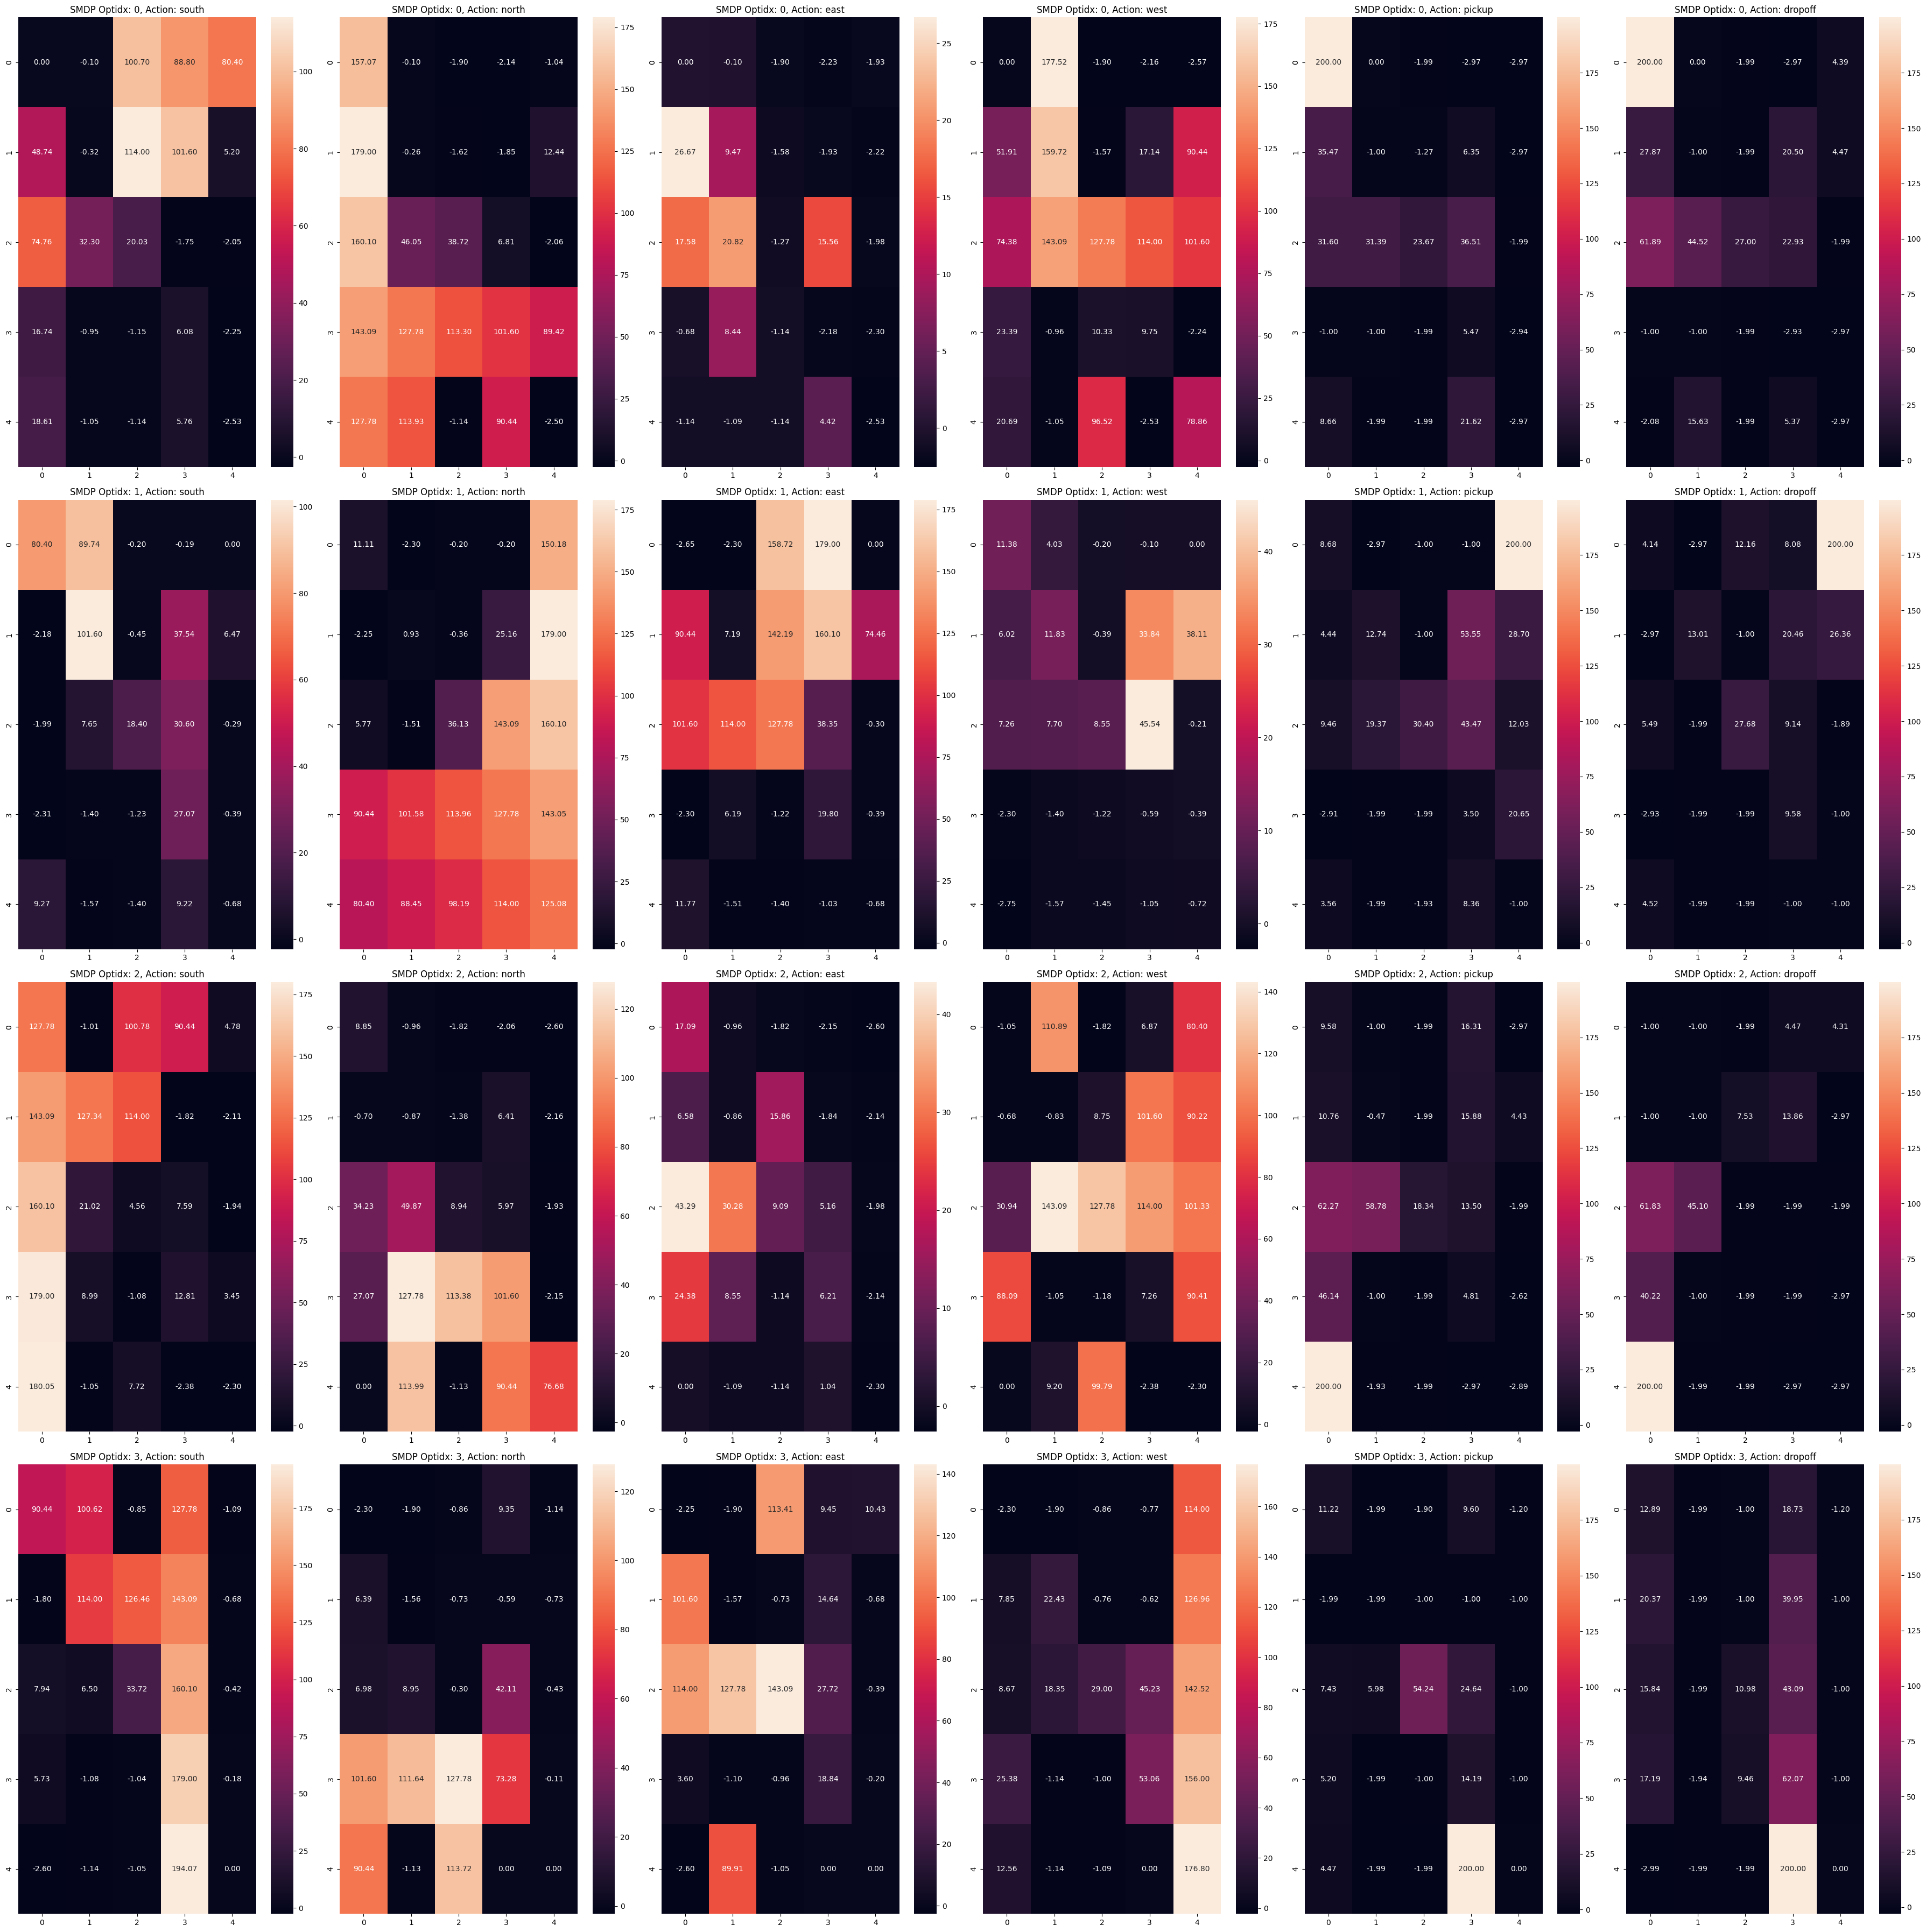

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pickup', 5: 'dropoff'}
action_names = ['south','north','east','west', 'pickup', 'dropoff']

fig, axs = plt.subplots(4, 6, figsize=(36, 36))

for optidx in range(4):
    actions = [Qopt[optidx][:, i].reshape(5,5) for i in range(6)]
    for i, ax in enumerate(axs[optidx]):
        sns.heatmap(actions[i], annot=True, fmt='.2f', ax=ax)
        ax.set_title(f'SMDP Optidx: {optidx}, Action: {action_names[i]}')

plt.tight_layout()
plt.show()


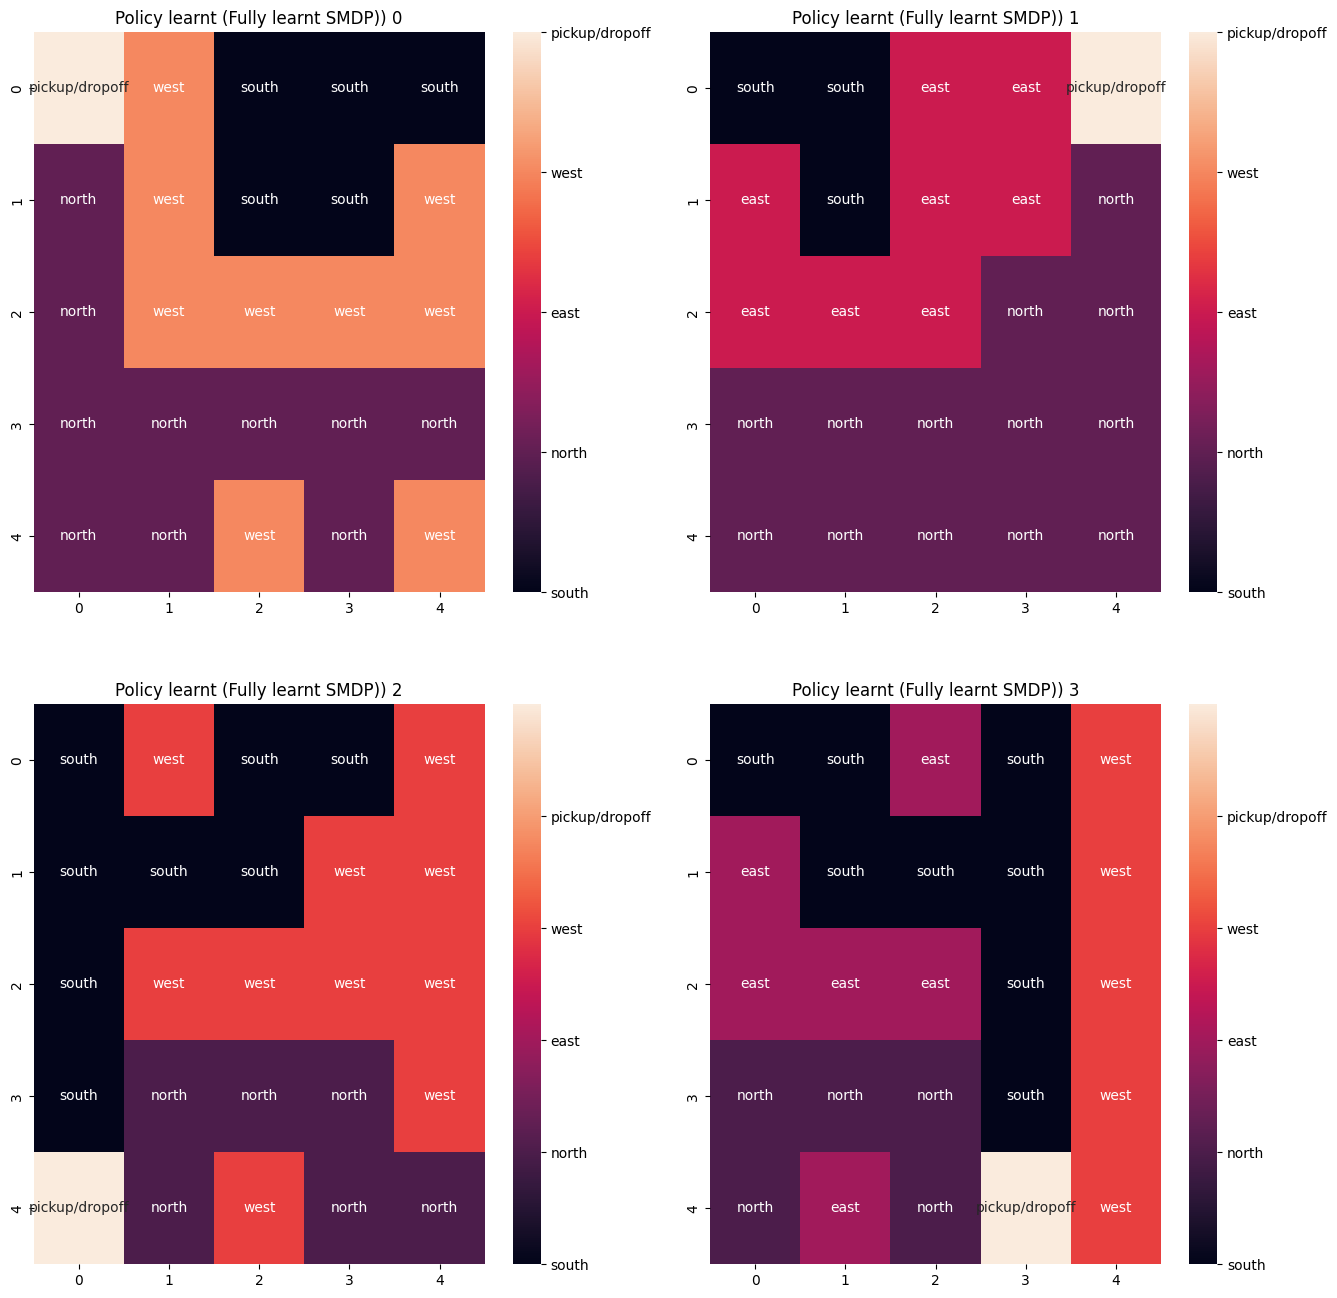

In [12]:
figure, axis = plt.subplots(2,2,figsize=(16,16))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pickup/dropoff', 5: 'pickup/dropoff'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt SMDP)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(5)])
    c_bar.set_ticklabels(['south','north','east','west', 'pickup/dropoff'])


# IOQL

In [13]:
def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = taxi_env.unwrapped.decode(state)
  subState = nDrop*pas+drop
  return subState

In [14]:
#### Intra Option Q-Learning

rewards_IOQL = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}


# Add parameters you might need here
gamma = 0.9
alpha = 0.1
nO = 4 #number of options
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_IOQL = np.zeros((nPas*nDrop,nO))
updates_IOQL = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((taxi_env.unwrapped.observation_space.n//20,taxi_env.unwrapped.action_space.n)) for i in range(nO)} #Q-values for each option


eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
N = 5000

# Iterate over N episodes
for i in range(N):
    state, _ = taxi_env.reset()
    done = False
    tot_rew=0

    # While episode is not over
    while not done:

        # Choose action
        _,_,pas,drop = taxi_env.unwrapped.decode(state)
        subState = nDrop*pas+drop
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)


        option = action
        optdone = False
        prev = state
        while not optdone and not done:

            optact,optdone = Option(taxi_env,state,Qopt,option,eps[option])
            next_state, reward, terminated, truncated,_ = taxi_env.step(optact)
            done = terminated or truncated
            tot_rew+=reward


            #Option Policy Learning
            [x,y,_,_]=  list(taxi_env.unwrapped.decode(state))
            [x1,y1,_,_]=  list(taxi_env.unwrapped.decode(next_state))



            eps[option] = max(eps_min,eps_decay*eps[option])
            reward_surr = reward
            if optdone:
              reward_surr = 20
            # if optact<4:
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call

            for o in range(nO):
              optact_o,optdone_o = Option(taxi_env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o])

                updates_IOQL[Sub(state), o] += 1
            state = next_state

    rewards_IOQL.append(tot_rew)
    x,y,pas,drop = taxi_env.unwrapped.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      # print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))



Same meaning of success rate as before.

Text(0.5, 1.0, 'IOQL')

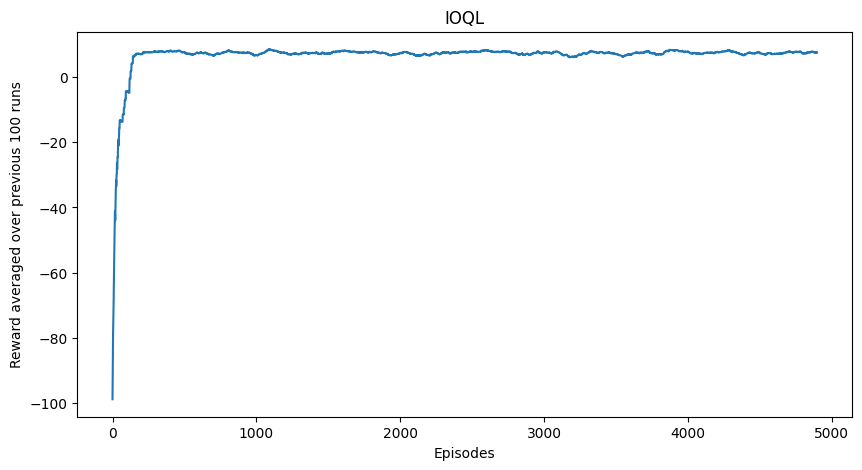

In [15]:
plt.figure(figsize = (10,5))
avg_rews_IOQL = [np.average(rewards_IOQL[i:i+100]) for i in range(len(rewards_IOQL)-100)]
plt.plot(avg_rews_IOQL,label = 'Model Score')
plt.xlabel('Episodes')
plt.ylabel('Reward averaged over previous 100 runs')
plt.title('IOQL')
# plt.legend()

Text(0.5, 1.0, 'Policy over default actions learnt by Intra Options')

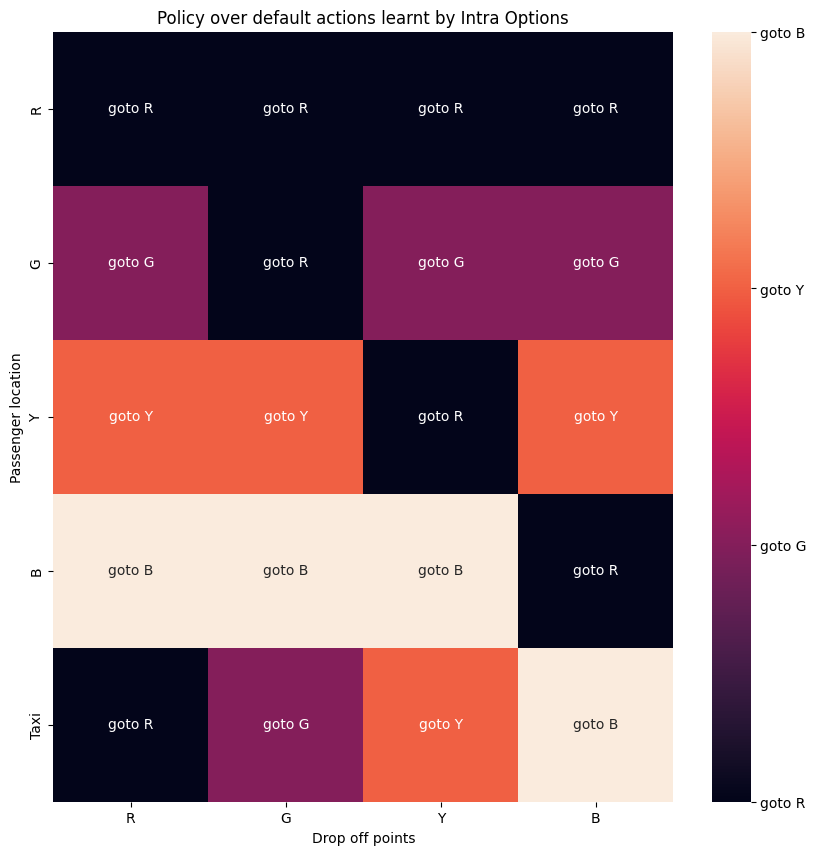

In [16]:
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_IOQL)

figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over default actions learnt by Intra Options')

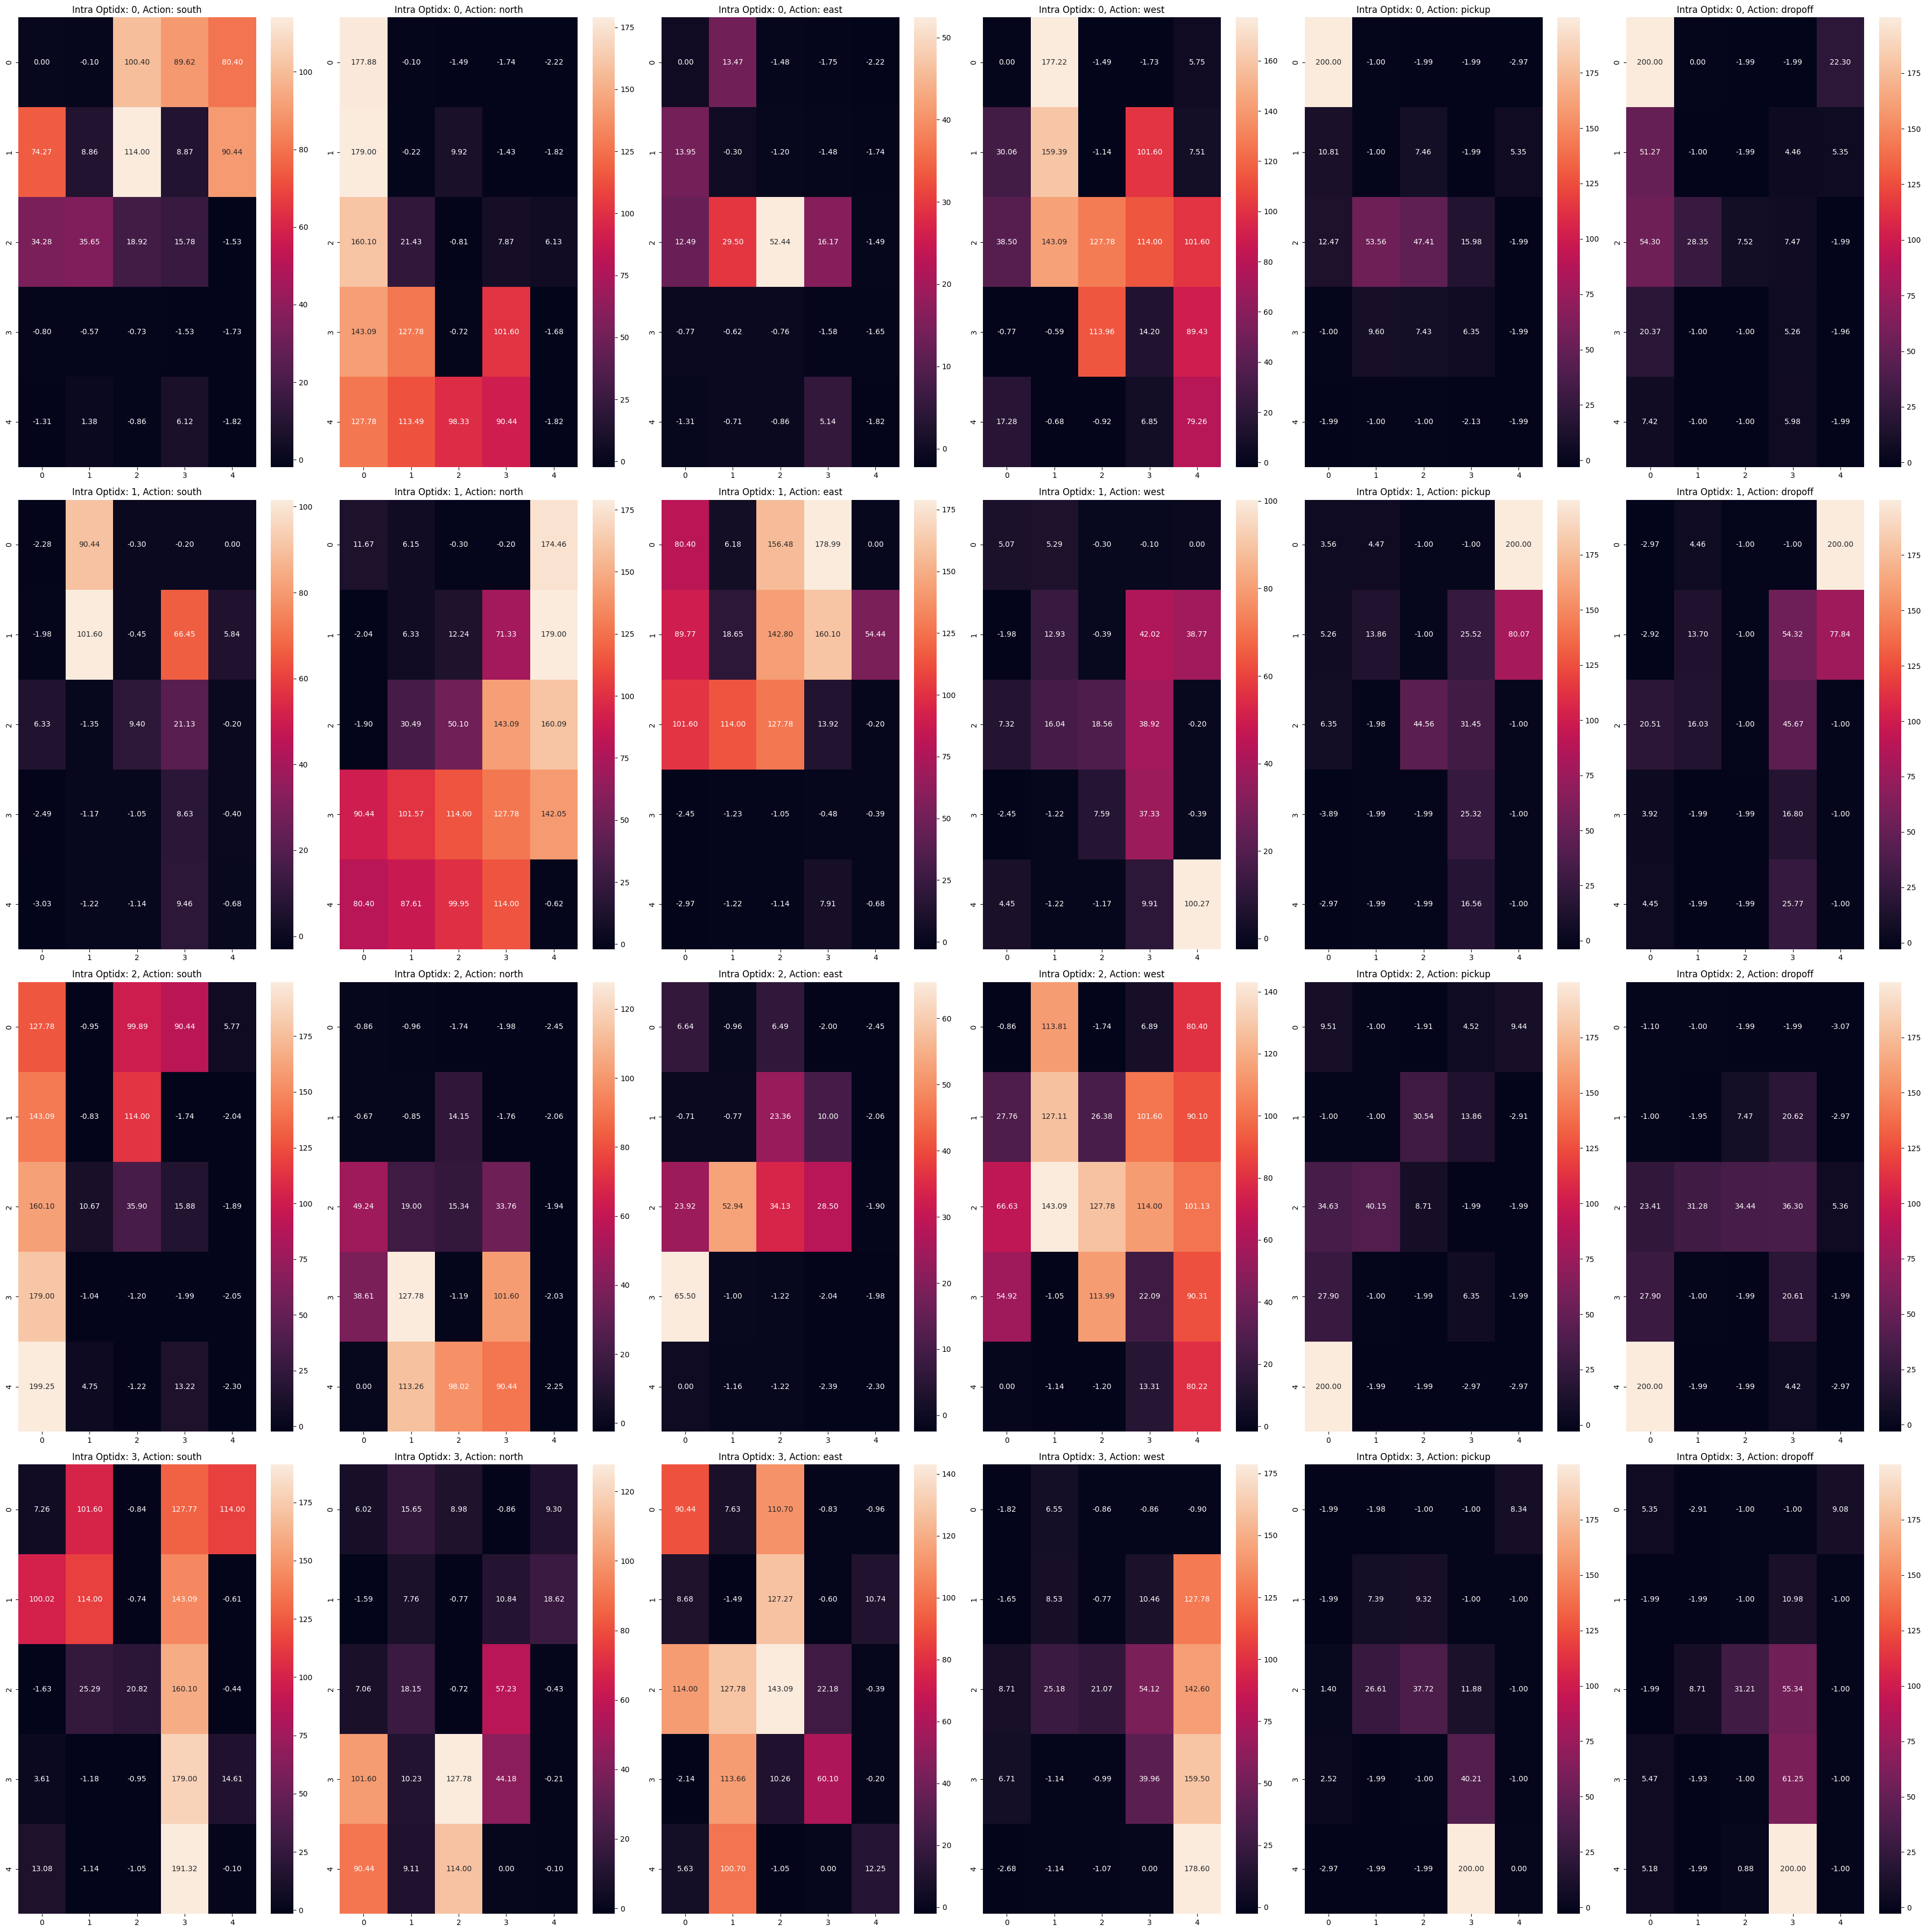

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pickup', 5: 'dropoff'}
action_names = ['south','north','east','west', 'pickup', 'dropoff']

fig, axs = plt.subplots(4, 6, figsize=(36, 36))

for optidx in range(4):
    actions = [Qopt[optidx][:, i].reshape(5,5) for i in range(6)]
    for i, ax in enumerate(axs[optidx]):
        sns.heatmap(actions[i], annot=True, fmt='.2f', ax=ax)
        ax.set_title(f'Intra Optidx: {optidx}, Action: {action_names[i]}')

plt.tight_layout()
plt.show()


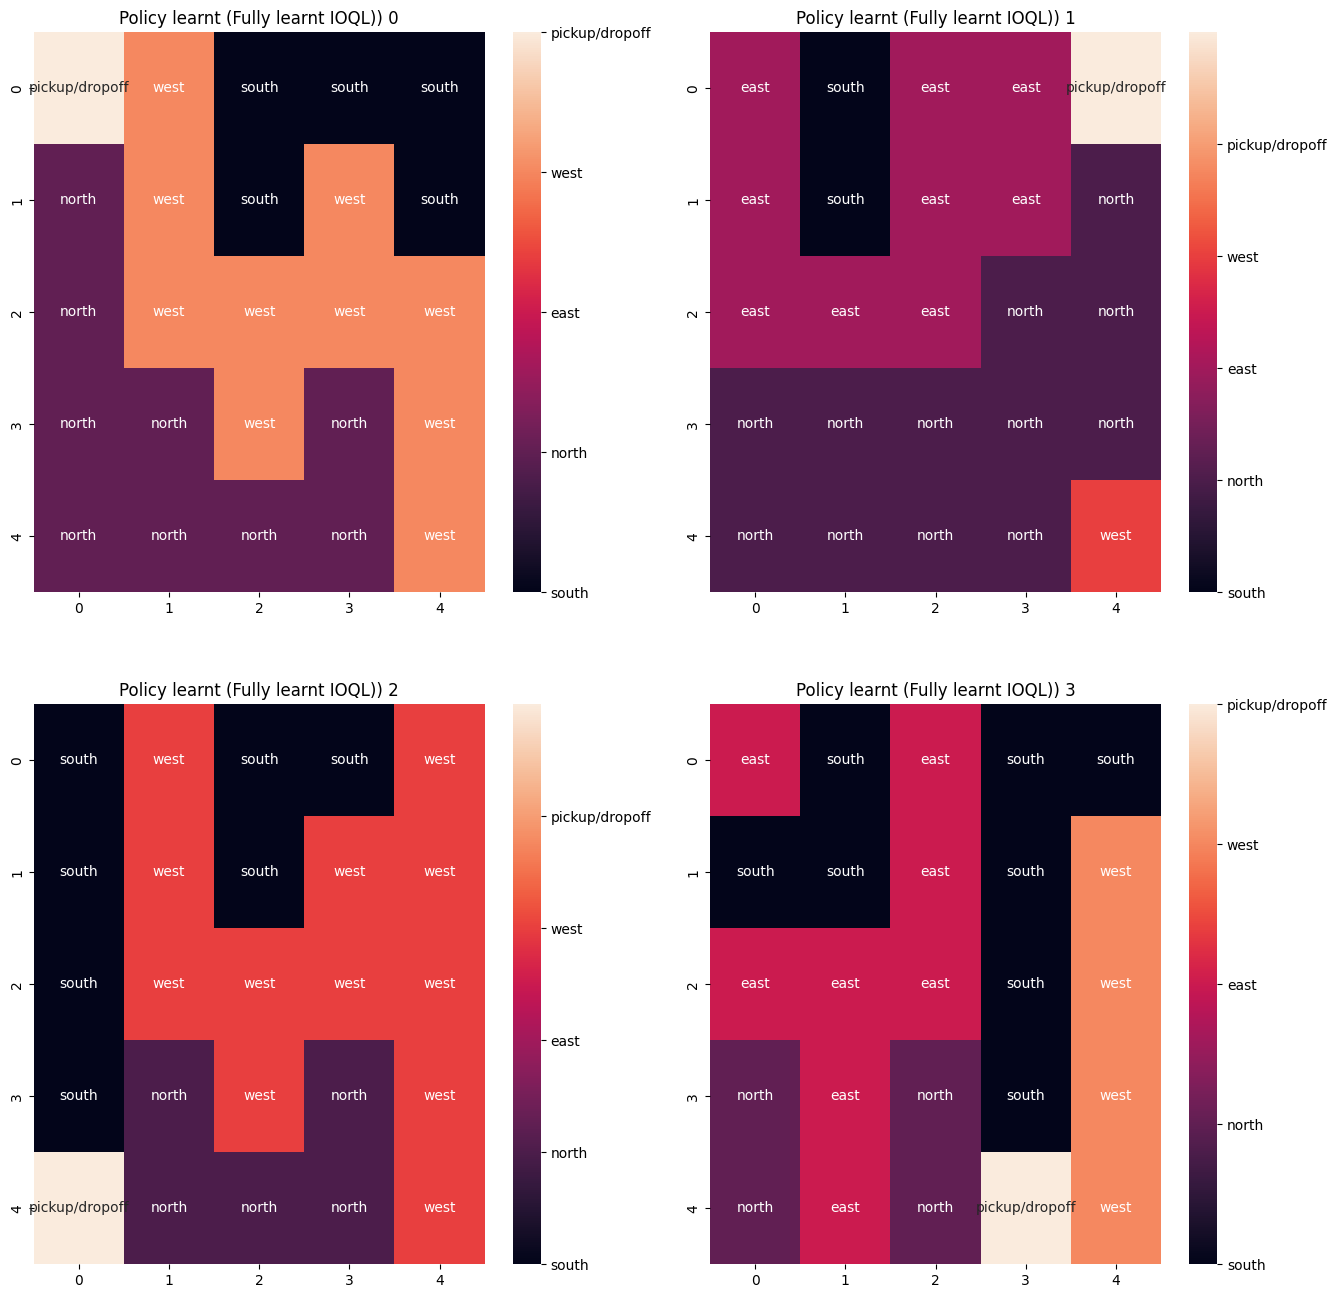

In [18]:
figure, axis = plt.subplots(2,2,figsize=(16,16))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west', 4: 'pickup/dropoff', 5: 'pickup/dropoff'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt IOQL)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(5)])
    c_bar.set_ticklabels(['south','north','east','west', 'pickup/dropoff'])


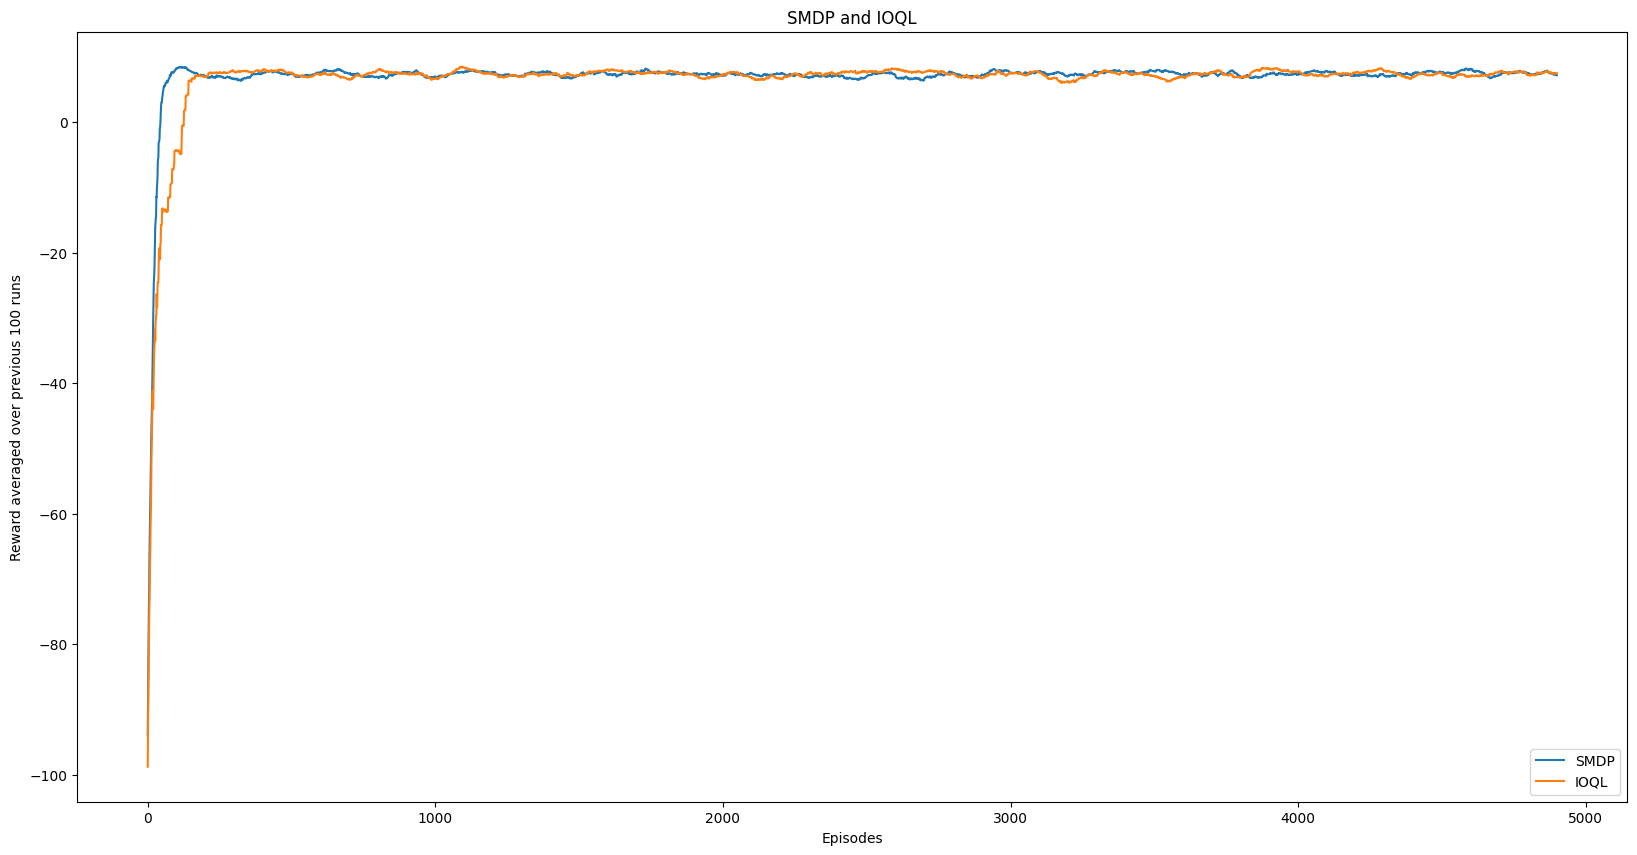

In [19]:
plt.figure(figsize = (20,10))
plt.plot(avg_rews_SMDP,label = 'SMDP')
plt.plot(avg_rews_IOQL,label = 'IOQL')
plt.xlabel('Episodes')
plt.ylabel('Reward averaged over previous 100 runs')
plt.title('SMDP and IOQL')
plt.legend()